In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import SALib
from SALib.sample import latin
import pandas as pd

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import spearmanr

mpl.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['text.usetex'] = False  # use latex for all text handling
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.format'] = 'png'  # gives best resolution plots
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
# print mpl.rcParams.keys()
mpl.rcParams['text.latex.preamble'] = \
    r'\usepackage{siunitx}\usepackage{amsmath}\usepackage{amssymb}'

figpath = '../output/gp_run_1024/figs/'

In [3]:
# def f(x, y):
#     """
#     not sensitive version
#     """
#     return -((x / 100 - 1)** 2 +  ((y - 1.5)**2) / 0.7 - x/100  * y / 4) + 1.5

# # with x fixed at value of 1.3
# def fix_f(x_fix, y_fix):
#     y_fix = np.linspace(-4, 12, 1000)
#     z_fix = f(x_fix, y_fix)
#     # return the average of z_fix[z_fix<=15]
#     z_fix = z_fix[z_fix<=15]
    
#     return z_fix

In [4]:
def f(x, y):
    """
    sensitive version
    """
    return (0.5 * (x - 0.5)** 2 +  ((y - 1)**2) / 0.3 + x * y / 0.9 + 1)

# with x fixed at value of 1.3
def fix_f(x_fix, y_fix):
    y_fix = np.linspace(-4, 12, 1000)
    z_fix = f(x_fix, y_fix)
    # return the average of z_fix[z_fix<=15]
    z_fix = z_fix[z_fix<=15]
    
    return z_fix

In [5]:
# calculate unconditional z
def fix_par(func, x1_value, x2_value, value_fix, par_lab='x1'):
    """
    This is the function used to fix parameter at different values.
    """
    a1 = value_fix[0] * np.ones_like(x2_value)
    a2 = value_fix[1] * np.ones_like(x2_value)
    if par_lab == 'x1':
        # set a to a1 and a2
        z_a1 = f(a1, x2_value)
        z_a2 = f(a2, x2_value)
    else:
        z_a1 = f(x1_value, a1)
        z_a2 = f(x1_value, a2)
    return z_a1, z_a2

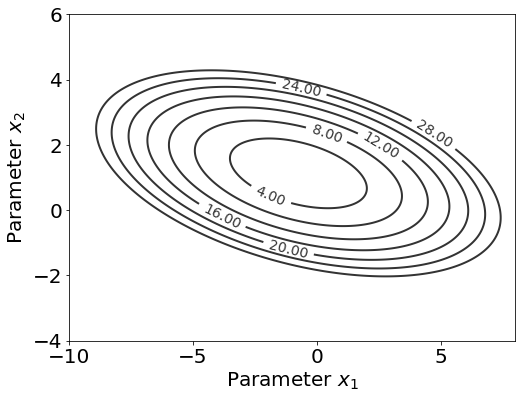

In [19]:
# plot contour
v_func = np.vectorize(f)   # major key!
x, y = np.meshgrid(np.linspace(-10, 8, 1000),
                   np.linspace(-4, 6, 1000))
z = v_func(x, y)

# plot contours
fig, ax = plt.subplots(1, figsize=(8, 6))
cs = ax.contour(x, y, z, levels=np.arange(0, 30, 4), colors='k', linestyles='solid', alpha=0.8, linewidths=2)
ax.clabel(cs, inline=1, fontsize=14, fmt='%.2f')
cs.set_clim(0, 15)
# cb = plt.colorbar(cs)
ax.set_xlabel('{}{}'.format('Parameter ', r'$x_{1}$'), fontsize= 20)
ax.set_ylabel('{}{}'.format('Parameter ', r'$x_{2}$'), fontsize= 20);
plt.savefig(f'{figpath}contour_nonsens.png', dpi=300, format='png')

##  Distribution analysis

In [6]:
# random sampling to over parameter space and then fix variable a
problem = {'num_vars': 2,
          'names': ['x1', 'x2'],
          'bounds': [[-10, 8], 
                    [-4, 6]]
          }
param_values_full = latin.sample(problem, 100000)
x1_full = param_values_full[:, 0]
x2_full = param_values_full[:, 1]
z_uncon = f(x1_full, x2_full)

In [7]:
# calculate the values when fixing x_1
fix_label = 'x1'
y_thr = -8
if fix_label == 'x1':
    value_fix = [-1.5, 0]
else:
    value_fix = [1.2, -1]
    
z_uncon_filter = z_uncon[(z_uncon>=y_thr)]
z_a1, z_a2 = fix_par(f, x1_full, x2_full, value_fix, par_lab=fix_label)
z_a1_filter = z_a1[(z_a1>=y_thr)]
z_a2_filter = z_a2[(z_a2>=y_thr)]

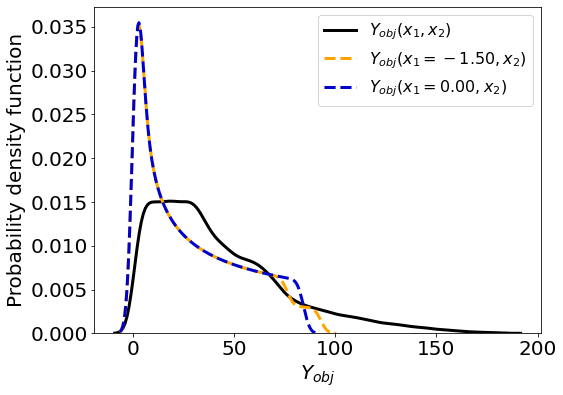

In [11]:
fig = plt.figure(figsize=(8,6))
ax = sns.kdeplot(z_uncon,color='k')
sns.kdeplot(z_a1,  color='orange', linestyle='--')
sns.kdeplot(z_a2, color='mediumblue', linestyle='--')
ax.set_xlabel(r'$Y_{obj}$', fontsize=20)
ax.set_ylabel('Probability density function', fontsize=20)
plt.legend([r'$Y_{obj}({x_{1}, x_{2}})$', r'$Y_{obj}({x_{1}=%.2f}, x_{2})$'%value_fix[0], r'$Y_{obj}({x_{1}=%.2f}, x_{2})$'%value_fix[1]], fontsize=16)
plt.savefig(f'{figpath}sensitive_pdf_x1.png', format='png', dpi=300);

## Boxplot
Boxplot of function outputs showing changes of objective functions

In [26]:
def box_obj(df, xlabel, ylabel, legend=None, figname=None):
    """
    This is the function for boxplot.
    """
    ax = df.boxplot(figsize=(8, 6))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if figname != None:
        plt.savefig(figname + '.png', dpi=300, format='png')

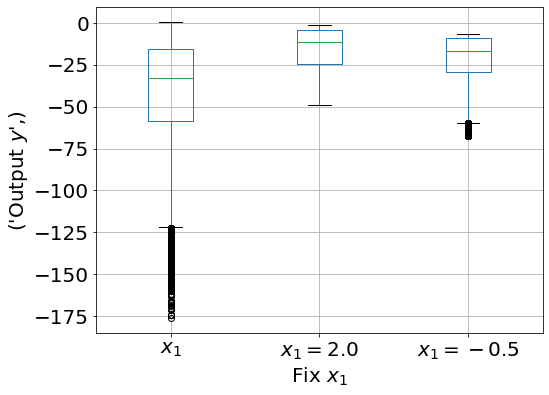

In [27]:
# box plot of the range used for contours
index_labels = [r'$x_{1}$', r'$x_{1}=%.1f$'%(value_fix[0]), r'$x_{1}=%.1f$'%(value_fix[1])]
x_label = r'Fix $x_{1}$'
y_label = r'Output $y$',
df = pd.DataFrame(index=index_labels, data=[z_uncon, z_a1, z_a2]).T
box_obj(df, x_label, y_label, figname=f'{figpath}dist_full_{fix_label}')

### boxplot of feasible set

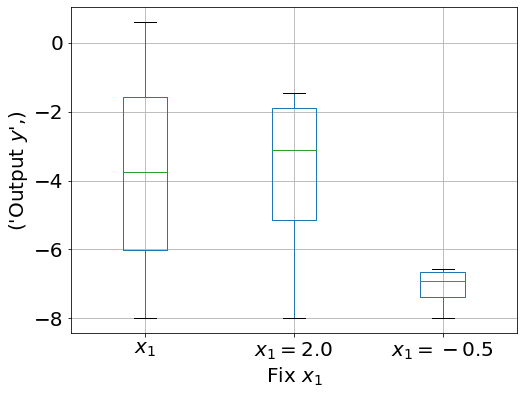

In [28]:
df = pd.DataFrame(index=index_labels, 
                  data=[z_uncon_filter, z_a1_filter, z_a2_filter]).T
box_obj(df, x_label, y_label, figname=f'{figpath}dist_feasible_set_{fix_label}')

### boxplot using feasbile range

In [29]:
# constrain the parameter ranges
z_index = np.where(z_uncon>=y_thr)
x1_min, x1_max = x1_full[z_index].min(), x1_full[z_index].max()
x2_min, x2_max = x2_full[z_index].min(), x2_full[z_index].max()

# random sampling to over parameter space and then fix variable a
problem_cons = {'num_vars': 2,
          'names': ['x1', 'x2'],
          'bounds': [[x1_min, x1_max], 
                    [x2_min, x2_max]]
          }
param_values_cons = latin.sample(problem_cons, 100)
x1_cons = param_values_cons[:, 0]
x2_cons = param_values_cons[:, 1]
z_uncon_cons = f(x1_cons, x2_cons)

# calculate the values when fixing x_1
z_uncon_cons_filter = z_uncon_cons[(z_uncon_cons>=y_thr)]
z_a1_cons, z_a2_cons = fix_par(f, x1_cons, x2_cons, value_fix, par_lab='x1')

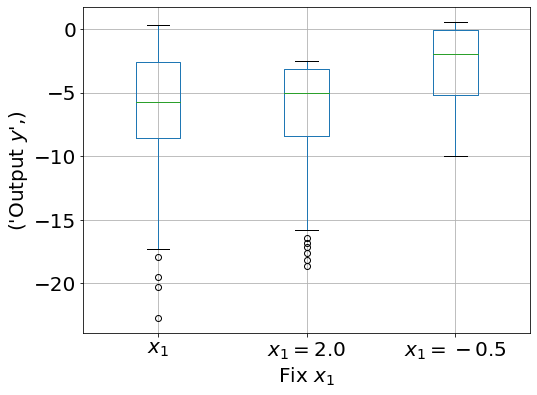

In [30]:
df = pd.DataFrame(index=index_labels, data=[z_uncon_cons, z_a1_cons, z_a2_cons]).T
box_obj(df, x_label, y_label, figname=f'{figpath}dist_feasible_region_{fix_label}')

## Fix X2

### boxplot

In [12]:
# calculate the values when fixing x_2
fix_label = 'x2'
if fix_label == 'x1':
    value_fix = [-1.5, 0]
else:
    value_fix = [1.2, -1]
z_a1, z_a2 = fix_par(f, x1_full, x2_full, value_fix, par_lab=fix_label)
# # box plot of the range used for contours
# df = pd.DataFrame(index=[r'$x_{1}$', r'$x_{1}=a$', r'$x_{2}=b$'], data=[z_uncon, z_a1, z_a2]).T
# box_obj(df, r'Fix $x_{1}$', 'Output y')

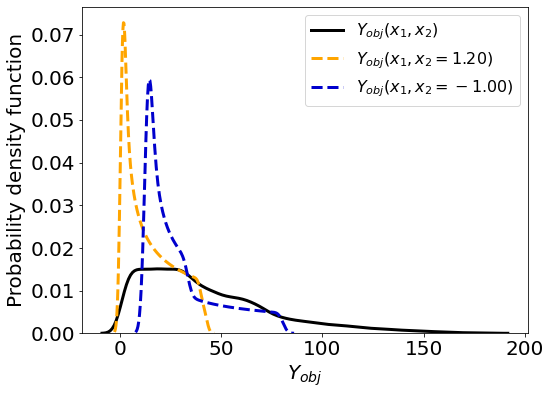

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = sns.kdeplot(z_uncon,color='k')
sns.kdeplot(z_a1,  color='orange', linestyle='--')
sns.kdeplot(z_a2, color='mediumblue', linestyle='--')
ax.set_xlabel(r'$Y_{obj}$', fontsize=20)
ax.set_ylabel('Probability density function', fontsize=20)
plt.legend([r'$Y_{obj}({x_{1}, x_{2}}$)', r'$Y_{obj}(x_{1}, {x_{2}=%.2f})$'%value_fix[0], 
            r'$Y_{obj}(x_{1}, {x_{2}=%.2f})$'%value_fix[1]], fontsize=16)
plt.savefig(f'{figpath}sensitive_pdf_x2.png', format='png', dpi=300);